# Milestone 3

In Milestone 1, our goal was to analyze the influence of ecological scandals on the society. After the review of the assistant, we have thought to slightly change the objective after our first analysis of the dataset. Indeed it was quite difficult to precisely define "ecological scandal" regarding the Gdelt dataset. Moreover, we had to define a precise metric of the "influence" which is quite troublesome. It would have required to do clustering or classification in a more detail manner. Thus, taking into account the timeline for the project, we deem wise to change the objectives of the project.


With the advice of the TA, we have chosen to enlarge the theme to "Environment" and our goal is now to analyse how media covers environment relate events in the world. We would like to know the principal actors, events, the impact on politics or economy of environment issues from the news point of view.
**As such, we have updated the description and the research questions of the ReadMe.
We have explicited what we would like to do in each question and we invite the reader to first read these questions.**


We present here the pipeline we have adopted to answer these questions.


After Milestone 2, the TA suggest us to precie the [ReadMe](../README.md) with information about the used external datasets. We invite the reader to read this new ReadMe. We have also used the human development index as a measure of the development of a country. Moreover, we have continued answering the research questions as well as clarifiying some points, in particular the difference between the location of the event and the location of a news source.

### The data itself
Gdelt files do not contain the name of the columns, so from the GDELT documentation we have built pyspark schemas to be able to use meaningful names in our queries and preprocessing scripts.

Gdelt documentation:

**[GlobalKnowledgeGraph (GKG) V2.1](http://data.gdeltproject.org/documentation/GDELT-Global_Knowledge_Graph_Codebook-V2.1.pdf)**

**[GdeltEventDatabase V2.0](http://data.gdeltproject.org/documentation/GDELT-Event_Codebook-V2.0.pdf)**

**[Mention Table](http://data.gdeltproject.org/documentation/GDELT-Event_Codebook-V2.0.pdf)**

As said in the ReadMe, in order to filter the dataset and keep only the environment-related events we keep the items in GKG that contains one of the following tag in their V1THEMES field:
- ```ENV_[*]```: Everything related to environment (from biofuels to overfishing, solar energy, nuclear energy, deforestation...)
- ```SELF_IDENTIFIED_ENVIRON_DISASTER```: Articles where the text explicitly mentions "ecological disaster", "environmental catastrophe", etc
- ```NATURAL_DISASTER```: From floods to coldsnaps, wildfires to tornadoes
- ```MOVEMENT_ENVIRONMENTAL```: Environmental movements

**The [configuration file](cluster/config.py) shows the name and type of the different columns of the dataset as well as the Themes we have kept.**

We then join with the Mention table on the V2DOCUMENTIDENTIFIER mention and then we join the Mention table with GdeltEvent on GLOBALEVENTID to keep the environment-related events.


Moreover, the gdelt dataset contain a lot of null values. We need to keep this in mind when doing computation and fill in or filter this null values.


### Use of the cluster to reduce the dataset size (Milestone 2)
The entire Gdelt database available in the cluster is of TB. This is an enormous amount of data to deal with. Therefore, the first thing to do is to reduce the amount of data we are working on. Here we have used the cluster impressive processing power and memory to come up with parquet files that are treatable on our local machines. To this extent, we have to filtered out unnecessary columns (that is columns we will definitely not us in our analysis) but more importantly we need to filtered out information unrelated to environment.

We have written functions in [load_datasets.py](cluster/load_datasets.py) to load the different csv files for gkg, events and mentions and properly parse them with regards to the columns names. Then we drop out unwanted columns. 

For the gkg files, we first keep only records related to environment by regex filtering on the V1THEMES column. Then we tried to transpose the environment themes present in the V1THEMES to onehot columns (by first exploding this semi-column separated string of themes), but we found that the size of the parquet were to large with this solution. So because knowing which particular theme was present in a record was not important for our first research questions, we decided to simply not put this column in the parquets.

Then using these loading functions, we load ([process_data.py](cluster/process_data.py)) all the csv files and agregate them to three parquets: gkg, mentions and events (mentions are joined with gkg to filter out non-environment-related records and events are joined with the result of the last join).

Size of the parquets:
- GKG: 10.3 GB
- MENTIONS: 3.0 GB
- EVENT: 1.8 GB

### Important remark related to themes filter (after Milestone 2)

We have come up with an important issue while analziny our different visualizations. As described in the previous paragraph, our only filter on "Environment" events was to filter by the V1THEMES and take every line of the gkg files that have a specific theme in this column. However, by doing this, we had taken all the events that could have for instance only a small relation with environment and that have been given an environment label by GDELT. In other words, events that are not really linked to environment but had only one theme related to environment have been considered in our analysis. 

The following histogram shows the distribution of the ratio between themes related to environment over the total number of different themes per gkg line.

![](data/local_generated/env_themes_histogram.png)

We can see that the ratio is concentrated around 0.03. That means we need to fine another way to filter our data and to keep events that are really related to environment.

For this purpose, we saw that the V1Themes column is sorted over the order of appearance of themes in the article. In our case, if an article talk about a environment related issue, then for sure there will be an environment theme among the first themes of V1Themes. We have taken the first five themens of this column to filter the lines in gkg. The scrypt [gkg_env_tag_ratio.py](cluster/gkg_env_tag_ratio.py) does this second filtering. The size of the new GKG parquet is of 2.5 GB.

Finally, all the methods and scripts that were used in Milestone 2 were not modified, we have simply used this new GKG parquet. Concerning the join on mentions and events parquets, we did not have to compute them again, as we could simply join on the GKGRecordId of the new gkg parquet.

### Use of the cluser to get relevant data files

With the three parquets (gkg, mentions and events), we can now perform some computations before coming up with small enough parquets to deal with on local machines. 
Below, you can find the code that has generated the files needed for each of the part that we will discuss next. These files are present in the [data](data/from_cluster) folder.

- *mentions_counts_by_state_and_day_filtered_5themes.csv:* [mentions_counts.py](cluster/mentions_counts.py)
- *tone_mean_count_5themes_median.parquet:* [tone.py](cluster/tone.py)
- *tone_mentions_5themes_europe.parquet* [tone_mentions_europe.py](cluster/tone_mentions_europe.py)

### Use of external datasets and assets

Europe:

- *European countries:* [countries_cleaned_europe.csv](assets/countries_cleaned_europe.csv)
- *FIPS to ISO conversion:* [fips-10-4-to-iso-country-codes](assets/fips-10-4-to-iso-country-codes.csv)
- *European countries geolocalisation:* [europe.geojson](assets/europe.geojson)


Metrics:

- *EPI:* [epi2018countrysnapshotv01.csv](external_datasets/epi2018countrysnapshotv01.csv)
- *HDI:* [human_development_index_2017.csv](external_datasets/human_development_index_2017.csv)

# Analysis of the data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import findspark
findspark.init()

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pyspark
from pyspark.sql import *

import itertools
from networkx.algorithms.community.centrality import girvan_newman
from collections import Counter
from operator import itemgetter
from functools import partial
import json
import folium
import pygeoj
import branca
import altair as alt

In [4]:
spark = SparkSession.builder.getOrCreate()
%matplotlib inline

In [5]:
from local.helper import *

## Major actors

* *What are the major actors (person, organisation, country) involved in environment-related events?*

* *How strong is the link between them? Is there a type of actor that is more predominant than others?*

### WordCloud

* *What are the major actors (person, organisation, country) involved in environment-related events?*

We would like to plot the top persons, organizations and countries, that is the actors that are the most cited by the media, in order to see which one have the strongest influence on environmental news.

For Milestone 2, we used the Actor fields of the GdeltEvent database. However, it turned out that a lot of results were irrelevant (see Milestone2.ipynb). We then thought it could be better to use the V1LOCATIONS, V1PERSONS and V1ORGANIZATIONS fields of the GKG database. The results obtained for the overall top-actors are presented below.

In [6]:
DATA_PATH = "data/from_cluster/wordcloud_actors/"

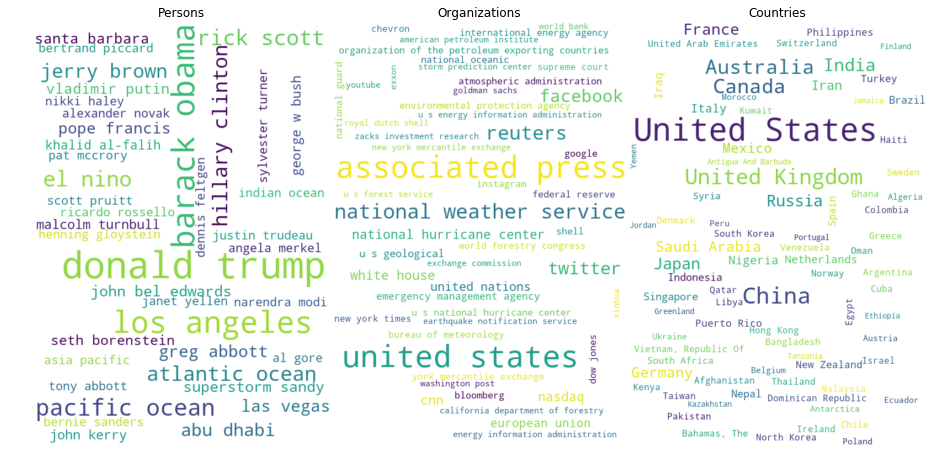

In [7]:
fig = plt.figure(figsize=(16, 16))
wordcloud_persons(DATA_PATH, 40, None, fig, 131)
wordcloud_organizations(DATA_PATH, 50, None, fig, 132)
wordcloud_countries(DATA_PATH, 80, None, fig, 133)
fig.subplots_adjust(hspace=0, wspace=0)
fig.savefig("../report/wordcloud_global.png")

The figures are generated using the [WordCloud](https://amueller.github.io/word_cloud/) library.

For the persons wordcloud, we simply group_by the actors names and then count the number of their occurences in the whole dataset. We do the same for the organizations wordcloud. For the countries wordcloud, we filtered the V1LOCATIONS on the first number which is 1 in case of a country and repeat the same procedure.

We can note that "Abu Dhabi", "Los Angeles", "Las Vegas" and others are wrongly treated as persons. Overall, the results obtained with the GKG database seem a lot more relevant for our problem. 

The first thing we can observe is that the dataset is clearly dominated by American actors which are over-represented in these wordclouds. This comes from the database itself which contains news coming mostly from american news agencies (such as associated press which appears a lot, as seen in the organizations wordcloud).

A lot of (American) politicians appears in the persons wordcloud. There are also mentions of ocean and storm (such as "El Niño" and "Superstorm Sandy") which come from the natural disaster related events we have kept in the GKG database. We can also see names of influential businessman such as André Borschberg (former student at EPFL!) and Elon Musk who have acted a lot for environment.

In the organizations wordcloud, big U.S. organizations are present. The major one is Associated Press which implies that a lot of articles come from this news agency. Other media are represented (Reuters, CNN, Bloomberg but also Facebook, Twitter and Google). There are also a lot of environmental organizations (such as atmospheric administration, national weather service, organizations of the petroleum exporting countries...). We can also notice the presence of big oil companies (Shell, Exxon and Chevron among others) which are linked to energy, mining operations, but also environmental scandals (see [Environmental damage in Ecuador](https://en.wikipedia.org/wiki/Chevron_Corporation#Controversies) for Chevron, [ExxonMobil climate change controversy](https://en.wikipedia.org/wiki/ExxonMobil_climate_change_controversy)).

In the countries wordcloud, the major countries are represented, such as the United States, China, the United Kingdom, Canada... There are also mention of other smaller countries which are prone to natural disasters, such as Haiti (see [Hurricane Matthew](https://en.wikipedia.org/wiki/Hurricane_Matthew) in 2016), The Bahamas (see [Hurricane Matthew](https://en.wikipedia.org/wiki/Hurricane_Matthew) in 2016, [Hurricane Joaquin](https://en.wikipedia.org/wiki/Hurricane_Joaquin) in 2015), Chile (see [Chile wildfires](https://en.wikipedia.org/wiki/2017_Chile_wildfires) in 2017), Afghanistan (see [Afghanistan avalanches](https://en.wikipedia.org/wiki/2017_Afghanistan_avalanches) in 2017), Puerto Rico (see [Caribbean drought](https://en.wikipedia.org/wiki/2015_Caribbean_drought) due to [El Niño](https://en.wikipedia.org/wiki/2014%E2%80%9316_El_Ni%C3%B1o_event) in 2015), Nepal (see [Mount Everest avalanches](https://en.wikipedia.org/wiki/2015_Mount_Everest_avalanches) in 2015), etc...

## Co-occurence graph

* *How strong is the link between them? Is there a type of actor that is more predominant than others?*

We would like to draw a co-occurence graph to see how persons and organizations are connected, as well as their predominance in the environment-related news.

We use the previously computed occurence_persons.csv and occurence_organizations.csv to plot the nodes size according to the occurence of an actor. To plot the edges, we count the number of times two actors are mentioned together in an article in the GKG database. The stronger the co-occurence, the larger the edges.

The graph for the top 50 persons and top 50 organizations is printed below. Organizations are printed in orange, persons in green.

The graph is plotted using the [NetworkX](https://networkx.github.io/documentation/stable/) Python library.

In [8]:
DATA_PATH = "data"

In [9]:
edge_size = 1e-5
node_weight_exp = 0.6
spacing = 8.5
figsize = 30

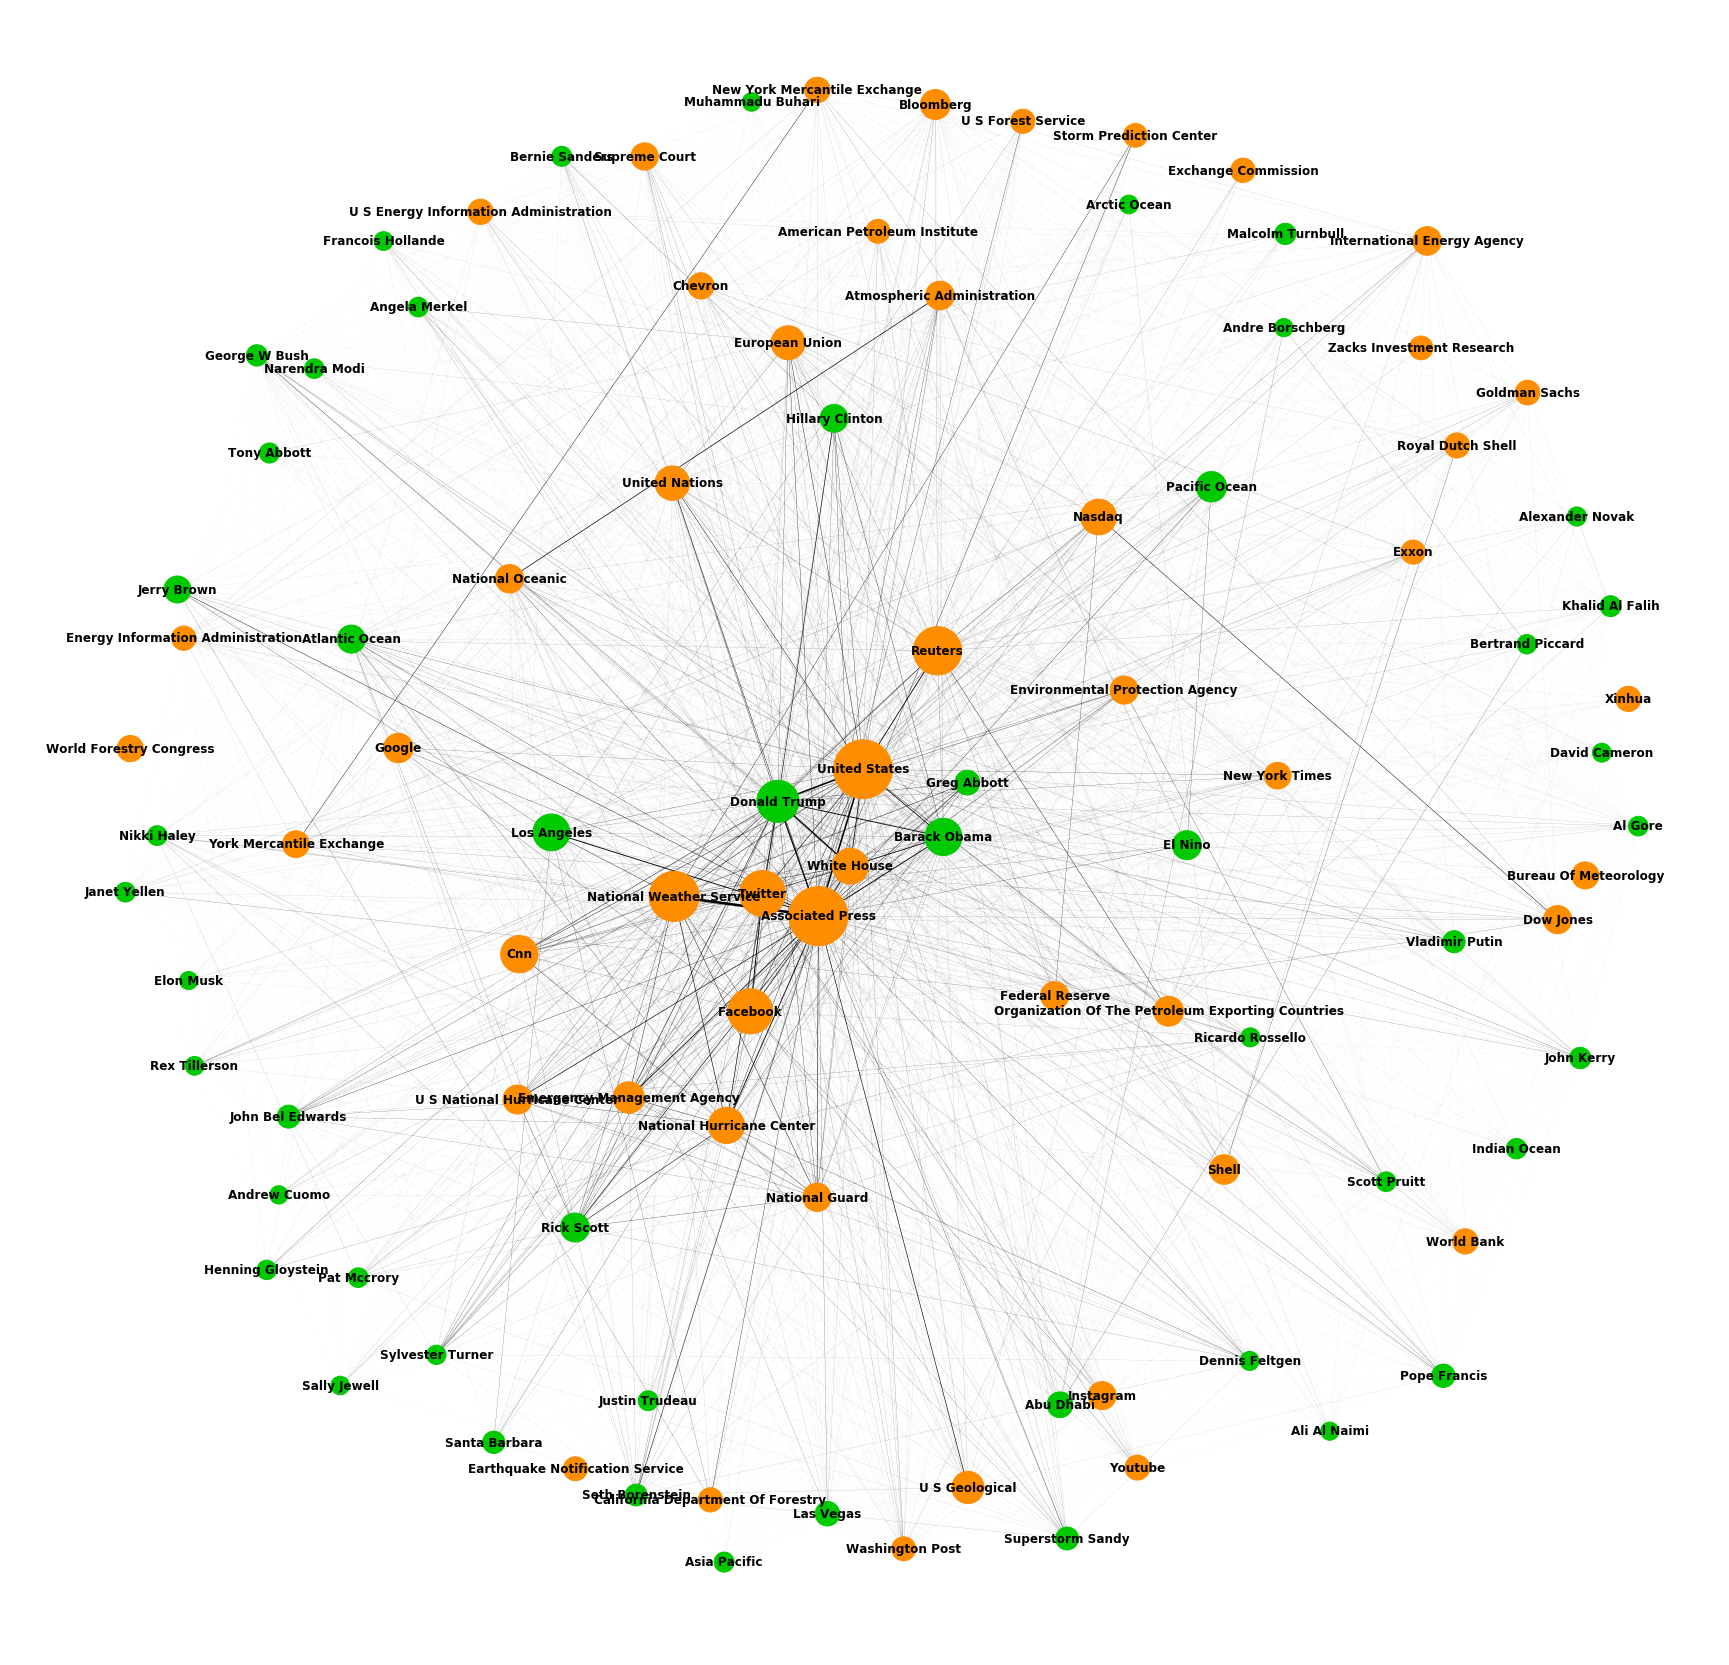

Name: 
Type: Graph
Number of nodes: 100
Number of edges: 4573
Average degree:  91.4600


In [26]:
G = plot_occ_graph(DATA_PATH, 'global_actors_co-occurences_50.zip', 50, edge_size, node_weight_exp, spacing, figsize)
print(nx.info(G))

In [25]:
print("Network sparsity: %.4f" %nx.density(G))
print(nx.is_connected(G))

Network sparsity: 0.9238
True


The network is very dense as seen with the high sparsity value (ratio between the number of edges and the maximum number of edges of the graph). The graph is a single connected component.

In [14]:
diameter = nx.diameter(G)
print("The diameter of the largest component is", diameter)

The diameter of the largest component is 2


Moreover the shortest path between any two actors is at most 2.

In [24]:
degrees = dict(G.degree(G.nodes(), "weight"))
sorted_degree = sorted(degrees.items(), key=itemgetter(1), reverse=True)

# And the top 20 most popular actors are.. 
print('Number of times an actor appears with one of the top 50 organizations or top 50 actor in an article:')
for actor, degree in sorted_degree[:25]:
    print(actor, ':', int(round(degree/edge_size)),)

Number of times an actor appears with one of the top 50 organizations or top 50 actor in an article:
Associated Press : 2290318
United States : 1631406
Donald Trump : 1520188
National Weather Service : 1020555
White House : 903552
Twitter : 847201
Barack Obama : 764626
National Hurricane Center : 683871
Facebook : 613382
Reuters : 570493
Emergency Management Agency : 535748
Cnn : 426654
Rick Scott : 425501
National Guard : 413713
Los Angeles : 366350
U S National Hurricane Center : 340455
United Nations : 324065
Hillary Clinton : 322415
European Union : 307205
Greg Abbott : 294027
Atmospheric Administration : 253989
National Oceanic : 253080
Nasdaq : 247029
Atlantic Ocean : 237804
Environmental Protection Agency : 234802


We would now want to see if we can isolate communities in our graph. For this we use the Louvain algorithm for community detection, provided by NetworkX package.

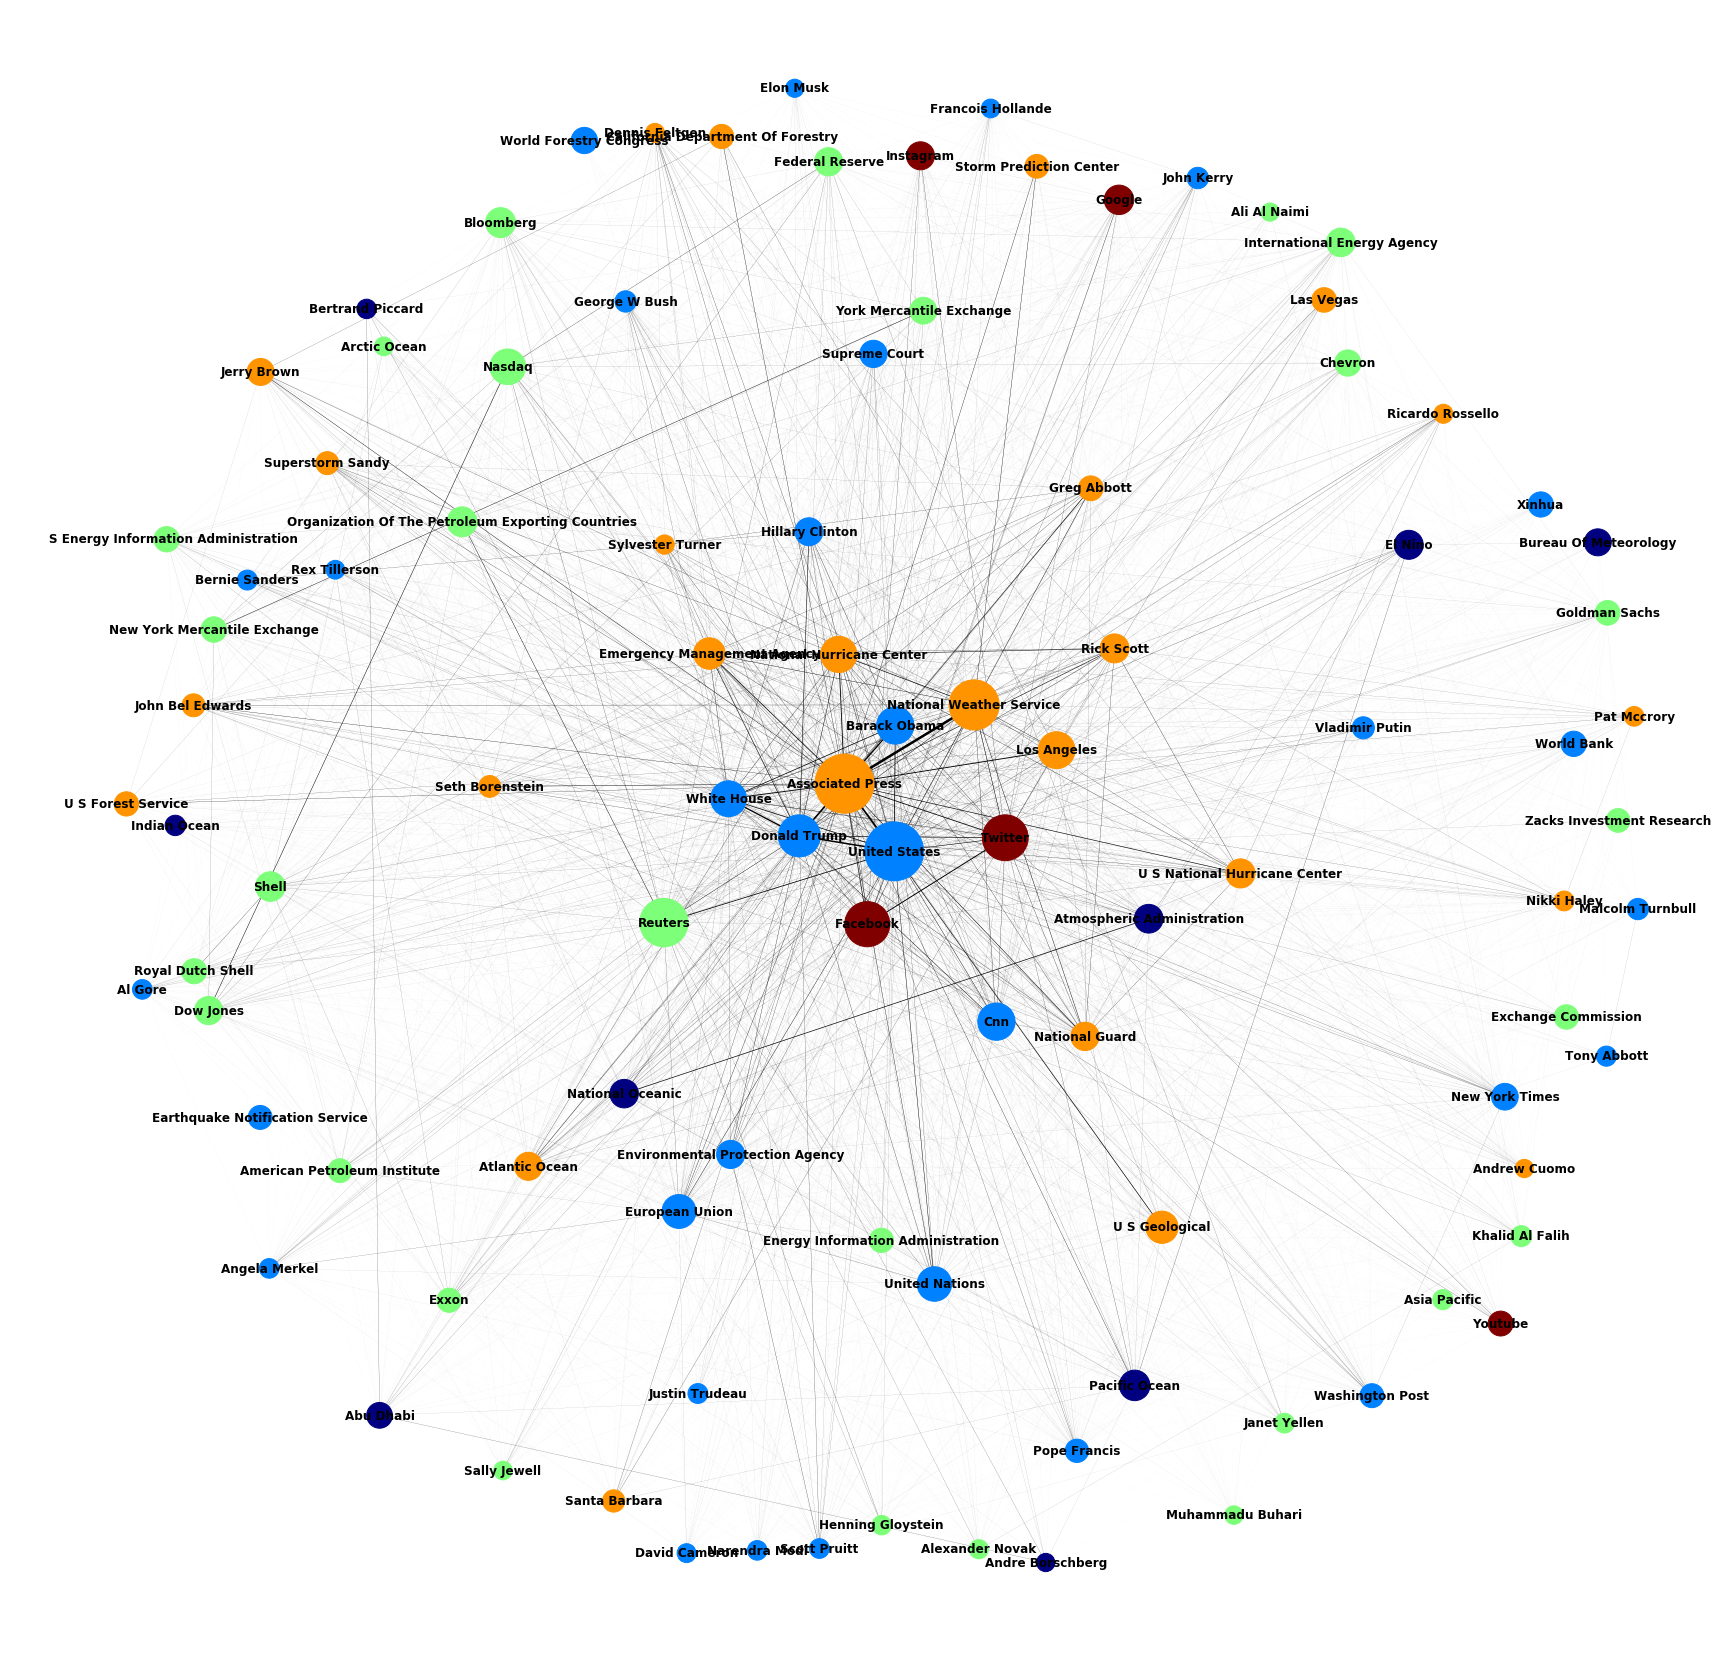

In [20]:
G_comm = plot_occ_graph(DATA_PATH, 'global_actors_co-occurences_50.zip', 50, edge_size, node_weight_exp, spacing, figsize, community_detection=True)

Communities appear as different node color. In red we have the big web companies that mediate a lot of information. In green, we have everything related to economy and energy. In orange are the actors in America. In blue we have all other international actors. In dark blue are the ocean and related organization. We have also two actors that are very familiar to us which are Bertrand Piccard and André Borschberg who did the ...